In [66]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

import numpy as np
from scipy.optimize import minimize

In [67]:
# dij需求i到设施j的成本
d = [[1, 2], [1, 2]]
n = 2   # 两个设施点
m = 2   # 两个需求点
num_qubits = n + 2 * n * m

# gi设施i的建设成本
g = [2, 1]

In [68]:
GateX = np.array([[0, 1],[1, 0]])
GateY = np.array([[0, -1j],[1j, 0]])
GateZ = np.array([[1, 0],[0, -1]])

# 定义σ+和σ-矩阵
sigma_plus = np.array([[0, 1], [0, 0]])
sigma_minus = np.array([[0, 0], [1, 0]])

def add_in_target(num_qubits, target_qubit, gate=np.array([[1, 0],[0, -1]])):
    H = np.eye(2 ** (target_qubit))
    H = np.kron(H, gate)
    H = np.kron(H, np.eye(2 ** (num_qubits - 1 - target_qubit)))
    return H

def generate_Hp(n, m, d, g):
    # 初始化 Hp 矩阵为零矩阵
    Hp = np.zeros((2**num_qubits, 2**num_qubits))
    for i in range(m):
        for j in range(n):
            Hp += d[i][j] * (add_in_target(num_qubits, n * (1 + i) + j) - np.eye(2**num_qubits)) / 2
    
    for j in range(n):
        Hp +=  g[j] * (add_in_target(num_qubits, j)- np.eye(2**num_qubits)) / 2
    return Hp
        
Hp = generate_Hp(n, m, d, g)


In [69]:
import sys
sys.path.append('../../')
import z_library.linear_system as ls

In [70]:
def gnrt_gate_hdi(u):
    result = []
    nonzero_indices = ls.find_nonzero_indices(u)
    for urow, nrow in zip(u, nonzero_indices):
        # 把非0元素映射成01
        filtered_arr = [0 if x == -1 else 1 for x in urow if x != 0]
        binary_str = ''.join(map(str, filtered_arr))
        # 取到二进制表示的数
        map_num = int(binary_str, 2)
        # print(map_num)
        length = len(nrow)
        scale = 2**length
        matrix = np.zeros((scale, scale))

        matrix[map_num, scale - 1 - map_num] = 1
        map_num = 2**length - 1 - map_num
        # print(map_num)
        matrix[map_num, scale - 1 - map_num] = 1
        result.append(matrix)
    return result

# print("非零元素的索引：", nonzero_indices)

u = ls.gnrt_u(n, m)
print(u)
nonzero_indices = ls.find_nonzero_indices(u)
gate_hds = gnrt_gate_hdi(u)
print(nonzero_indices)

[[-1.  1. -1.  1. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  1. -1.  0.  0. -1.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  1.  0.  1.  0.]
 [ 0.  1. -1.  1.  0.  0.  1.  0.  0.  1.]]
[[0, 1, 2, 3, 4, 5], [2, 3, 6, 7], [0, 6, 8], [1, 2, 3, 6, 9]]


In [71]:
gnrt_gate_hdi(u)[1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [72]:
from scipy.linalg import expm
def build_circ(params):
  depth = len(params) // 2
  qc = QuantumCircuit(num_qubits)
  gamma = params
  for i in [1,3,4,6,8,9]:
    qc.x(i)
  for dp in range(depth):
    # qc.unitary(expm(-1j * beta[dp] * Hp), range(num_qubits))
    for gate_hdi, ind in zip(gate_hds, nonzero_indices):
      qc.unitary(expm(-1j * gamma[dp] * gate_hdi), (num_qubits - 1 - i for i in ind))
  qc.measure_all()
  return qc

In [73]:
ls.set_print_form()
build_circ(np.full(2 * 2, np.pi/3)).draw()

┌──────────┐            »
    q_0: ─────────────────────────────────────────┤4         ├────────────»
         ┌───┐                        ┌──────────┐│          │            »
    q_1: ┤ X ├────────────────────────┤2         ├┤          ├────────────»
         └───┘            ┌──────────┐│          ││          │            »
    q_2: ─────────────────┤3         ├┤          ├┤          ├────────────»
         ┌───┐            │          ││          ││          │            »
    q_3: ┤ X ├────────────┤2         ├┤1         ├┤3         ├────────────»
         ├───┤┌──────────┐│          ││          ││          │┌──────────┐»
    q_4: ┤ X ├┤5         ├┤          ├┤          ├┤  Unitary ├┤5         ├»
         └───┘│          ││  Unitary ││          ││          ││          │»
    q_5: ─────┤4         ├┤          ├┤  Unitary ├┤          ├┤4         ├»
         ┌───┐│          ││          ││          ││          ││          │»
    q_6: ┤ X ├┤3         ├┤1         ├┤          ├┤2         ├┤3         ├»
         └───┘│  Unitary ││          ││          ││          ││  Unitary │»
    q_7: ─────┤2         ├┤0         ├┤          ├┤1         ├┤2         ├»
         ┌───┐│          │└──────────┘│          ││          ││          │»
    q_8: ┤ X ├┤1         ├────────────┤          ├┤0         ├┤1         ├»
         ├───┤│          │            │          │└──────────┘│          │»
    q_9: ┤ X ├┤0         ├────────────┤0         ├────────────┤0         ├»
         └───┘└──────────┘            └──────────┘            └──────────┘»
meas: 10/═════════════════════════════════════════════════════════════════»
                                                                          »
«                                 ┌──────────┐ ░ ┌─┐                           
«    q_0: ────────────────────────┤4         ├─░─┤M├───────────────────────────
«                     ┌──────────┐│          │ ░ └╥┘┌─┐                        
«    q_1: ────────────┤2         ├┤          ├─░──╫─┤M├────────────────────────
«         ┌──────────┐│          ││          │ ░  ║ └╥┘┌─┐                     
«    q_2: ┤3         ├┤          ├┤          ├─░──╫──╫─┤M├─────────────────────
«         │          ││          ││          │ ░  ║  ║ └╥┘┌─┐                  
«    q_3: ┤2         ├┤1         ├┤3         ├─░──╫──╫──╫─┤M├──────────────────
«         │          ││          ││          │ ░  ║  ║  ║ └╥┘┌─┐               
«    q_4: ┤          ├┤          ├┤  Unitary ├─░──╫──╫──╫──╫─┤M├───────────────
«         │  Unitary ││          ││          │ ░  ║  ║  ║  ║ └╥┘┌─┐            
«    q_5: ┤          ├┤  Unitary ├┤          ├─░──╫──╫──╫──╫──╫─┤M├────────────
«         │          ││          ││          │ ░  ║  ║  ║  ║  ║ └╥┘┌─┐         
«    q_6: ┤1         ├┤          ├┤2         ├─░──╫──╫──╫──╫──╫──╫─┤M├─────────
«         │          ││          ││          │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐      
«    q_7: ┤0         ├┤          ├┤1         ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├──────
«         └──────────┘│          ││          │ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
«    q_8: ────────────┤          ├┤0         ├─░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───
«                     │          │└──────────┘ ░  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
«    q_9: ────────────┤0         ├─────────────░──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
«                     └──────────┘             ░  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
«meas: 10/════════════════════════════════════════╩══╩══╩══╩══╩══╩══╩══╩══╩══╩═
«                                                 0  1  2  3  4  5  6  7  8  9

In [74]:
def cost_function(x):
  num = [int(char) for char in x]
  C = 0
  for i in range(m):
    for j in range(n):
      C += d[i][j] * num[n * (1 + i) + j]
      
  for j in range(n):
    C += g[j] * num[j]
  return C

def compute_expectation(counts):
  EV = 0
  total_count = 0
  for x, count in counts.items():
    C = cost_function(x)
    EV += C*count
    total_count += count

  return EV/total_count


def expectation_from_sample(shots = 2000):
  backend = Aer.get_backend('qasm_simulator')
  backend.shots = shots

  def execute_circ(theta):
    qc = build_circ(theta)
    counts = backend.run(qc, seed_simulator=10, shots=shots).result().get_counts()
    return compute_expectation(counts)
  
  return execute_circ

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize iteration counter and expectation values list
iteration_count = 0
expectation_values = []

# Initialize parameters list
parameters_history = []

def test(par):
    global iteration_count
    global expectation_values
    global parameters_history
    iteration_count = 0
    expectation_values = []
    parameters_history = []
    
    expectation = expectation_from_sample()
    
    def callback(x):
        global iteration_count
        global expectation_values
        global parameters_history
        iteration_count += 1
        expectation_value = expectation(x)
        expectation_values.append(expectation_value)
        parameters_history.append(x)
    
    # Set maximum number of iterations
    max_iterations = 1000

    # Use COBYLA method for minimization and set the callback function
    res = minimize(expectation, par, method='COBYLA', options={'maxiter': max_iterations}, callback=callback)
    
    backend = Aer.get_backend('aer_simulator')
    backend.shots = 100000

    shots = 100000
    qc_res = build_circ(params=res.x)

    counts = backend.run(qc_res, seed_simulator=10, shots=shots).result().get_counts()
    
    sorted_counts = sorted(counts, key=counts.get, reverse=True)
    
    for x in sorted_counts[:20]:
        if cost_function(x) == 4:
            print(f"共迭代次数:{iteration_count}" , "{:.2f}%".format(counts[x] / shots * 100))
            break
    
    sorted_data1 = sorted(zip(parameters_history, expectation_values), key=lambda x: x[0][0])
    sorted_parameters1 = [params for params, _ in sorted_data1]
    sorted_expectations1 = [expectation for _, expectation in sorted_data1]
    par_1 = [params[0] for params in sorted_parameters1]


    
    # Plot par_1 vs. expectation values
    plt.figure(figsize=(4, 3))
    plt.plot(par_1, sorted_expectations1, marker='o', linestyle='-')
    plt.xlabel('par_1')
    plt.ylabel('Expectation Value')
    plt.title('Parameter 1')


    plt.tight_layout()
    plt.show()




denominator == 1


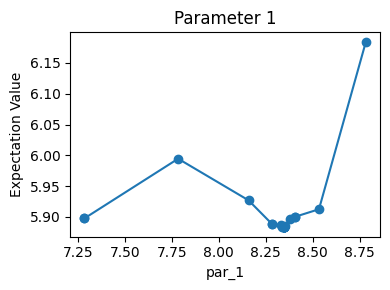

denominator == 2


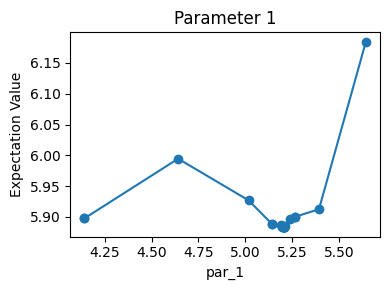

denominator == 3


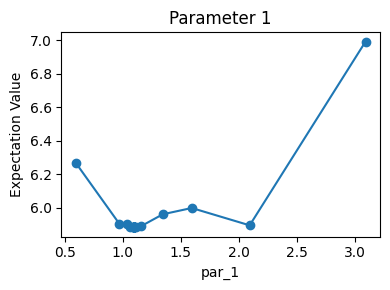

denominator == 4


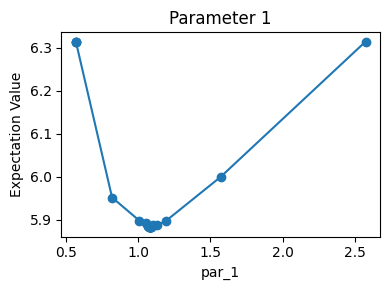

denominator == 5


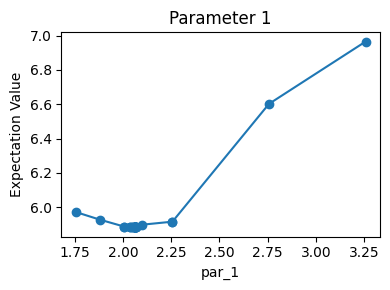

denominator == 6


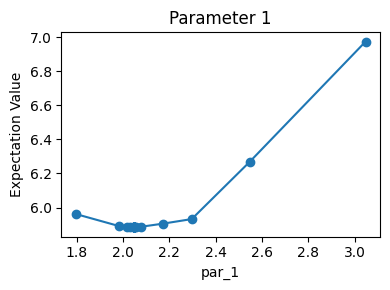

denominator == 7


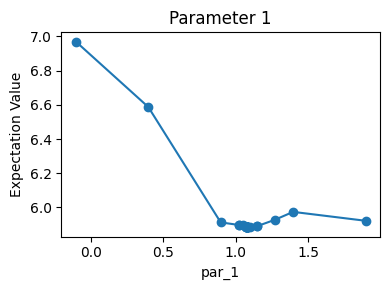

denominator == 8


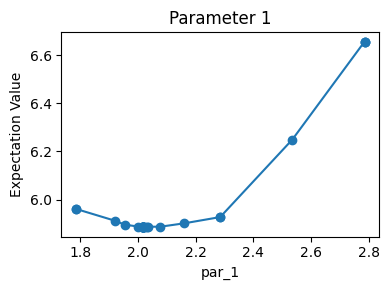

denominator == 9


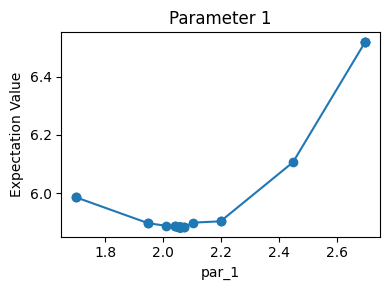

In [76]:
dep = 2
for denominator in range(1,10):
  print(f'denominator == {denominator}')
  test(np.full(dep, 2 * np.pi/denominator))